# BiLSTM + Transformer Hybrid with KMeans Clustering for Sleep Pattern Analysis

This notebook implements a hybrid BiLSTM-Transformer model for learning embeddings from physiological signals, followed by KMeans clustering to discover hidden sleep states.

## Pipeline Overview:

1. **DMD Feature Extraction**: Extract temporal features from EEG/physiological signals using Dynamic Mode Decomposition
2. **Sequence Creation**: Create overlapping sequences suitable for training
3. **Hybrid Model Training**: Train a BiLSTM-Transformer hybrid model for embedding learning
4. **Embedding Extraction**: Extract learned embeddings from the trained model
5. **KMeans Clustering**: Apply KMeans clustering to discover distinct sleep states
6. **Visualization**: Visualize clustering results and temporal patterns

## Key Components:

- **DMD-based feature extraction** from physiological signals (3-second windows)
- **BiLSTM layers** for temporal sequence modeling
- **Transformer layers** for attention-based pattern recognition
- **KMeans clustering** for discovering hidden states in the embedding space
- **Visualization tools** for analyzing clustering results and temporal patterns

## Process Flow:

1. Load and preprocess EEG/physiological data
2. Extract DMD features using sliding windows
3. Create overlapping sequences for training
4. Train hybrid BiLSTM-Transformer model
5. Extract embeddings from trained model
6. Apply KMeans clustering
7. Visualize and analyze results

## Section 1: Import Required Libraries

Import all necessary libraries for the pipeline including deep learning frameworks, signal processing, and clustering tools.

In [31]:
# Core libraries
import numpy as np
import pandas as pd
import os
import json
import warnings
from datetime import datetime
import math
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence

# Signal processing and EEG
import mne
from scipy.signal import butter, filtfilt
from scipy.stats import mode
from mne.time_frequency import psd_array_multitaper

# DMD for feature extraction
from pydmd import DMD, EDMD

# Machine learning and clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("Warning: CUDA not available. Using CPU.")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("✓ All libraries imported successfully!")

Using device: cuda
GPU: NVIDIA GeForce GTX 1080 Ti
CUDA version: 12.4
Number of GPUs: 1
✓ All libraries imported successfully!


## Section 2: Data Loading and Preprocessing

Load EEG/EDF files, normalize signals, apply bandpass filtering, and remove outliers using a sliding window approach.

In [17]:
def bandpass_filter(signal, sfreq, low=0.5, high=40, order=4):
    """Apply bandpass filter to EEG signal."""
    nyq = 0.5 * sfreq
    lowcut = low / nyq
    highcut = high / nyq
    b, a = butter(order, [lowcut, highcut], btype='band')
    filtered = filtfilt(b, a, signal)
    return filtered

def load_and_preprocess_edf(filepath, num_channels=4, window_sec=30, std_factor=3):
    """Load and preprocess multiple channels from an EDF file.
    
    Parameters:
    -----------
    filepath : str
        Path to the EDF file
    num_channels : int
        Number of channels to load (default: 4)
    window_sec : int
        Window size in seconds for outlier removal
    std_factor : int
        Standard deviation multiplier for outlier detection
        
    Returns:
    --------
    signals : list of numpy.ndarray
        List of preprocessed signals
    sfreqs : list of int
        List of sampling frequencies for each signal
    channel_names : list of str
        List of channel names
    """
    print(f"Loading EDF file: {filepath}")
    raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
    
    # Get channel names and make sure we don't request more than available
    all_channels = raw.ch_names
    num_channels = min(num_channels, len(all_channels))
    channels_to_use = all_channels[:num_channels]
    
    signals = []
    sfreqs = []
    
    print(f"Processing {num_channels} channels: {channels_to_use}")
    
    # Process each channel
    for i, channel in enumerate(channels_to_use):
        print(f"  Processing channel {i+1}/{num_channels}: {channel}")
        
        # Extract signal and sampling frequency for this channel
        signal = raw.get_data(picks=channel)[0]
        sfreq = int(raw.info['sfreq'])
        
        # Bandpass filter 0.5-40Hz (for sleep stage analysis)
        signal = bandpass_filter(signal, sfreq, low=0.5, high=40)
        
        # Normalize to [-1, 1]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        signal_norm = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
        
        # Remove outliers in sliding windows
        win_samples = window_sec * sfreq
        cleaned = signal_norm.copy()
        
        for start in range(0, len(signal_norm), win_samples):
            end = min(start + win_samples, len(signal_norm))
            window = signal_norm[start:end]
            mean = np.mean(window)
            std = np.std(window)
            mask = np.abs(window - mean) < std_factor * std
            window_cleaned = np.where(mask, window, mean)
            cleaned[start:end] = window_cleaned
            
        signals.append(cleaned)
        sfreqs.append(sfreq)
        
        print(f"    Signal length: {len(cleaned)} samples ({len(cleaned)/sfreq:.1f} seconds)")
    
    print(f"✓ Successfully loaded {len(signals)} channels")
    return signals, sfreqs, channels_to_use

# EDF file list for processing
edf_files = [
    "raw data/SC4001E0-PSG.edf", "raw data/SC4002E0-PSG.edf", "raw data/SC4011E0-PSG.edf", "raw data/SC4012E0-PSG.edf",
      "raw data/SC4021E0-PSG.edf", "raw data/SC4022E0-PSG.edf", "raw data/SC4031E0-PSG.edf", "raw data/SC4032E0-PSG.edf",
        "raw data/SC4041E0-PSG.edf", "raw data/SC4042E0-PSG.edf", "raw data/SC4051E0-PSG.edf", "raw data/SC4052E0-PSG.edf",
          "raw data/SC4061E0-PSG.edf", "raw data/SC4062E0-PSG.edf", "raw data/SC4071E0-PSG.edf", "raw data/SC4072E0-PSG.edf",
            "raw data/SC4081E0-PSG.edf", "raw data/SC4082E0-PSG.edf", "raw data/SC4091E0-PSG.edf", "raw data/SC4092E0-PSG.edf"
]

print(f"Will process {len(edf_files)} EDF files")

Will process 20 EDF files


## Section 3: Feature Extraction with DMD on 3-second Windows

Extract DMD features (magnitude and phase) from each 3-second window of the preprocessed signals.

### Section 3a: Load Pre-extracted Features (Optional)

If you have already extracted DMD features, use these functions to load them instead of re-processing the EDF files.

In [18]:
def load_extracted_features(features_dir='features_3s', file_pattern='*_features_3s.npy'):
    """
    Load pre-extracted DMD features from disk.
    
    Parameters:
    -----------
    features_dir : str
        Directory containing the extracted features
    file_pattern : str
        Pattern to match feature files
        
    Returns:
    --------
    feature_dict : dict
        Dictionary containing features for each file and channel
    """
    import glob
    
    if not os.path.exists(features_dir):
        raise FileNotFoundError(f"Features directory '{features_dir}' not found. Please extract features first.")
    
    # Find all feature files
    feature_files = glob.glob(os.path.join(features_dir, file_pattern))
    timestamp_files = glob.glob(os.path.join(features_dir, '*_timestamps_3s.npy'))
    
    if not feature_files:
        raise FileNotFoundError(f"No feature files found in '{features_dir}' matching pattern '{file_pattern}'")
    
    print(f"Found {len(feature_files)} feature files in {features_dir}")
    
    feature_dict = {}
    
    # Parse file names to organize by file and channel
    for feature_file in feature_files:
        basename = os.path.basename(feature_file)
        # Expected format: {file_basename}_{channel}_features_3s.npy
        parts = basename.replace('_features_3s.npy', '').split('_')
        
        if len(parts) >= 2:
            # Join all parts except the last one as file name
            file_name = '_'.join(parts[:-1])
            channel = parts[-1]
        else:
            print(f"Warning: Could not parse file name {basename}, skipping...")
            continue
        
        # Find corresponding timestamp file
        timestamp_file = feature_file.replace('_features_3s.npy', '_timestamps_3s.npy')
        
        if not os.path.exists(timestamp_file):
            print(f"Warning: Timestamp file not found for {basename}, skipping...")
            continue
        
        # Load features and timestamps
        try:
            features = np.load(feature_file)
            timestamps = np.load(timestamp_file)
            
            # Initialize file entry if not exists
            if file_name not in feature_dict:
                feature_dict[file_name] = {}
            
            # Store in dictionary
            feature_dict[file_name][channel] = {
                'features': features,
                'time_stamps': timestamps,
                'sfreq': 100  # Default sampling frequency, adjust if needed
            }
            
            print(f"Loaded {file_name} - {channel}: {features.shape[0]} windows, {features.shape[1]} features")
            
        except Exception as e:
            print(f"Error loading {basename}: {e}")
            continue
    
    if not feature_dict:
        raise ValueError("No valid features were loaded. Please check your feature files.")
    
    print(f"\n✓ Successfully loaded features for {len(feature_dict)} files")
    
    # Print summary
    total_windows = 0
    for file_name, channels in feature_dict.items():
        print(f"  {file_name}: {len(channels)} channels")
        for channel, data in channels.items():
            total_windows += len(data['features'])
            print(f"    - {channel}: {len(data['features'])} windows")
    
    print(f"\nTotal feature windows: {total_windows}")
    
    return feature_dict

print("✓ Feature loading function defined")

✓ Feature loading function defined


In [19]:
def check_feature_compatibility(feature_dict, expected_channels=None):
    """
    Check if loaded features are compatible with the pipeline.
    
    Parameters:
    -----------
    feature_dict : dict
        Dictionary of loaded features
    expected_channels : list or None
        List of expected channel names
        
    Returns:
    --------
    bool
        True if features are compatible
    """
    if not feature_dict:
        print("❌ No features found")
        return False
    
    # Get first file for compatibility checking
    first_file = next(iter(feature_dict))
    first_channels = feature_dict[first_file]
    
    # Check if all files have the same channels
    reference_channels = set(first_channels.keys())
    
    for file_name, channels in feature_dict.items():
        file_channels = set(channels.keys())
        if file_channels != reference_channels:
            print(f"❌ Channel mismatch in {file_name}")
            print(f"   Expected: {reference_channels}")
            print(f"   Found: {file_channels}")
            return False
    
    # Check feature dimensions
    for channel, data in first_channels.items():
        features = data['features']
        if len(features.shape) != 2:
            print(f"❌ Invalid feature shape for {channel}: {features.shape}")
            return False
        
        print(f"✓ {channel}: {features.shape[0]} windows × {features.shape[1]} features")
    
    # Check expected channels if provided
    if expected_channels:
        missing_channels = set(expected_channels) - reference_channels
        if missing_channels:
            print(f"❌ Missing expected channels: {missing_channels}")
            return False
    
    print(f"✓ Features are compatible with the pipeline")
    return True

print("✓ Feature compatibility checking function defined")

✓ Feature compatibility checking function defined


In [20]:
def get_input_dimensions_from_features(feature_dict):
    """
    Extract input dimensions from loaded features.
    
    Parameters:
    -----------
    feature_dict : dict
        Dictionary of loaded features
        
    Returns:
    --------
    input_dims : dict
        Dictionary of input dimensions for each channel
    """
    first_file = next(iter(feature_dict))
    input_dims = {
        channel: data['features'].shape[1]
        for channel, data in feature_dict[first_file].items()
    }
    
    print(f"Input dimensions: {input_dims}")
    return input_dims

print("✓ Input dimensions extraction function defined")

✓ Input dimensions extraction function defined


In [21]:
def load_features_if_available(features_dir='features_3s', force_reextract=False):
    """
    Load features if available, otherwise return None to trigger re-extraction.
    
    Parameters:
    -----------
    features_dir : str
        Directory to check for features
    force_reextract : bool
        If True, skip loading and force re-extraction
        
    Returns:
    --------
    feature_dict : dict or None
        Loaded features or None if not available/invalid
    """
    if force_reextract:
        print("Forcing re-extraction of features...")
        return None
    
    try:
        feature_dict = load_extracted_features(features_dir)
        
        if check_feature_compatibility(feature_dict):
            print(f"✓ Using pre-extracted features from {features_dir}")
            return feature_dict
        else:
            print(f"❌ Features incompatible, will re-extract")
            return None
            
    except (FileNotFoundError, ValueError) as e:
        print(f"Features not available: {e}")
        print("Will extract features from EDF files...")
        return None

print("✓ Conditional feature loading function defined")

✓ Conditional feature loading function defined


In [22]:
def import_all_saved_features(features_dir='features_3s'):
    """
    Import all saved features from the features directory.
    This function automatically loads all available features and returns them
    in the same format used by the pipeline.
    
    Parameters:
    -----------
    features_dir : str
        Directory containing saved features
        
    Returns:
    --------
    tuple: (feature_dict, input_dims, summary)
        - feature_dict: Dictionary of all loaded features
        - input_dims: Dictionary of input dimensions for model
        - summary: Dictionary with loading summary statistics
    """
    print(f"{'='*60}")
    print(f"IMPORTING ALL SAVED FEATURES FROM: {features_dir}")
    print(f"{'='*60}")
    
    # Check if directory exists
    if not os.path.exists(features_dir):
        print(f"❌ Features directory '{features_dir}' not found!")
        print(f"Please extract features first using process_all_files_dmd()")
        return None, None, None
    
    # Load all features
    try:
        feature_dict = load_extracted_features(features_dir)
        
        # Validate compatibility
        if not check_feature_compatibility(feature_dict):
            print(f"❌ Loaded features are not compatible with the pipeline")
            return None, None, None
        
        # Get input dimensions
        input_dims = get_input_dimensions_from_features(feature_dict)
        
        # Create summary statistics
        summary = {
            'total_files': len(feature_dict),
            'channels_per_file': len(next(iter(feature_dict.values()))),
            'channel_names': list(next(iter(feature_dict.values())).keys()),
            'total_windows': 0,
            'features_per_window': next(iter(next(iter(feature_dict.values())).values()))['features'].shape[1],
            'files': {}
        }
        
        # Calculate detailed statistics
        for file_name, channels in feature_dict.items():
            file_windows = 0
            file_info = {}
            
            for channel, data in channels.items():
                n_windows = len(data['features'])
                file_windows += n_windows
                file_info[channel] = {
                    'windows': n_windows,
                    'features': data['features'].shape[1],
                    'duration_seconds': data['time_stamps'][-1] - data['time_stamps'][0] + 3  # +3 for last window
                }
            
            summary['files'][file_name] = {
                'total_windows': file_windows,
                'channels': file_info
            }
            summary['total_windows'] += file_windows
        
        # Print detailed summary
        print(f"\n{'='*60}")
        print(f"FEATURE IMPORT SUMMARY")
        print(f"{'='*60}")
        print(f"✓ Successfully imported features from {summary['total_files']} files")
        print(f"✓ Channels per file: {summary['channels_per_file']}")
        print(f"✓ Channel names: {', '.join(summary['channel_names'])}")
        print(f"✓ Features per window: {summary['features_per_window']}")
        print(f"✓ Total feature windows: {summary['total_windows']:,}")
        
        print(f"\nPER-FILE BREAKDOWN:")
        for file_name, file_info in summary['files'].items():
            print(f"\n📁 {file_name}:")
            print(f"   Total windows: {file_info['total_windows']:,}")
            for channel, channel_info in file_info['channels'].items():
                print(f"   - {channel}: {channel_info['windows']:,} windows ({channel_info['duration_seconds']:.1f}s)")
        
        print(f"\n{'='*60}")
        print(f"✅ FEATURES READY FOR PIPELINE")
        print(f"{'='*60}")
        print(f"You can now proceed with:")
        print(f"1. create_sequences_from_features(feature_dict, ...)")
        print(f"2. train_hybrid_model(sequences_dict, input_dims, ...)")
        print(f"\nInput dimensions for model: {input_dims}")
        
        return feature_dict, input_dims, summary
        
    except Exception as e:
        print(f"❌ Error importing features: {e}")
        print(f"Please check your features directory and try again.")
        return None, None, None

print("✓ Complete feature import function defined")

✓ Complete feature import function defined


### Implementation Example: Import All Features

Here's how to use the feature loading functions to import all your saved features:

In [23]:
# IMPORT ALL SAVED FEATURES
# This cell will import all features from the features_3s directory
# Run this instead of the DMD extraction if you already have features saved

# Import all saved features
feature_dict, input_dims, summary = import_all_saved_features('features_3s')

if feature_dict is not None:
    print(f"\n🎉 SUCCESS! Imported {summary['total_files']} files with {summary['total_windows']:,} total feature windows")
    print(f"Ready to proceed with sequence creation and model training!")
    
    # You can now use feature_dict and input_dims directly in the pipeline:
    # 1. sequences_dict = create_sequences_from_features(feature_dict, ...)
    # 2. model = train_hybrid_model(sequences_dict, input_dims, ...)
else:
    print(f"\n❌ Failed to import features. You'll need to extract them first using process_all_files_dmd()")

IMPORTING ALL SAVED FEATURES FROM: features_3s
Found 80 feature files in features_3s
Loaded SC4071E0-PSG - Resp oro-nasal: 84298 windows, 32 features
Loaded SC4081E0-PSG - EEG Pz-Oz: 83878 windows, 32 features
Loaded SC4071E0-PSG - Resp oro-nasal: 84298 windows, 32 features
Loaded SC4081E0-PSG - EEG Pz-Oz: 83878 windows, 32 features
Loaded SC4011E0-PSG - EOG horizontal: 84058 windows, 32 features
Loaded SC4032E0-PSG - EEG Pz-Oz: 81958 windows, 32 features
Loaded SC4011E0-PSG - EOG horizontal: 84058 windows, 32 features
Loaded SC4032E0-PSG - EEG Pz-Oz: 81958 windows, 32 features


Loaded SC4042E0-PSG - Resp oro-nasal: 83758 windows, 32 features
Loaded SC4032E0-PSG - EOG horizontal: 81958 windows, 32 features
Loaded SC4061E0-PSG - Resp oro-nasal: 83098 windows, 32 features
Loaded SC4071E0-PSG - EOG horizontal: 84298 windows, 32 features
Loaded SC4072E0-PSG - EOG horizontal: 83098 windows, 32 features
Loaded SC4061E0-PSG - Resp oro-nasal: 83098 windows, 32 features
Loaded SC4071E0-PSG - EOG horizontal: 84298 windows, 32 features
Loaded SC4072E0-PSG - EOG horizontal: 83098 windows, 32 features
Loaded SC4052E0-PSG - EEG Pz-Oz: 84178 windows, 32 features
Loaded SC4052E0-PSG - EEG Pz-Oz: 84178 windows, 32 features
Loaded SC4092E0-PSG - EOG horizontal: 85738 windows, 32 features
Loaded SC4071E0-PSG - EEG Fpz-Cz: 84298 windows, 32 features
Loaded SC4082E0-PSG - Resp oro-nasal: 79018 windows, 32 features
Loaded SC4092E0-PSG - EOG horizontal: 85738 windows, 32 features
Loaded SC4071E0-PSG - EEG Fpz-Cz: 84298 windows, 32 features
Loaded SC4082E0-PSG - Resp oro-nasal: 79018

### Section 3b: DMD Feature Extraction from EDF Files

If you don't have pre-extracted features, use these functions to extract DMD features from the raw EDF files.

In [24]:
def extract_dmd_features_3s(signal, sfreq, window_sec=3, step_sec=1, n_modes=8):
    """Extract DMD features from 3-second windows with 1-second steps.
    
    Parameters:
    -----------
    signal : numpy.ndarray
        Input signal array
    sfreq : float
        Sampling frequency in Hz
    window_sec : int
        Window size in seconds (fixed at 3 for this pipeline)
    step_sec : int
        Step size in seconds (1 for high temporal resolution)
    n_modes : int
        Number of DMD modes to extract
        
    Returns:
    --------
    features : numpy.ndarray
        Extracted DMD features (n_windows x n_features)
    time_stamps : numpy.ndarray
        Time stamps for each window
    """
    win_samples = int(window_sec * sfreq)
    step_samples = int(step_sec * sfreq)
    
    # Calculate number of windows
    n_windows = (len(signal) - win_samples) // step_samples + 1
    
    features = []
    time_stamps = []
    
    print(f"Extracting DMD features from {n_windows} windows (3s each, 1s step)...")
    
    # Use tqdm for progress tracking
    for start in tqdm(range(0, len(signal) - win_samples + 1, step_samples), 
                      desc="DMD feature extraction"):
        
        window = signal[start:start + win_samples]
        
        # Create DMD instance
        dmd = DMD(svd_rank=n_modes)
        
        # Fit DMD model to the window data
        # DMD expects data in format (n_features, n_samples)
        dmd.fit(window.reshape(1, -1))
        
        # Extract magnitude and phase features from the amplitudes
        if len(dmd.amplitudes) >= n_modes:
            amplitudes = dmd.amplitudes[:n_modes]
        else:
            # Pad with zeros if fewer modes than expected
            amplitudes = np.pad(dmd.amplitudes, (0, n_modes - len(dmd.amplitudes)), 
                              mode='constant', constant_values=0)
        
        feat_mag = np.abs(amplitudes)  # Magnitude features
        feat_phase = np.angle(amplitudes)  # Phase features
        
        # Also extract eigenvalues (frequency and growth rate information)
        if len(dmd.eigs) >= n_modes:
            eigenvalues = dmd.eigs[:n_modes]
        else:
            eigenvalues = np.pad(dmd.eigs, (0, n_modes - len(dmd.eigs)), 
                               mode='constant', constant_values=0)
        
        feat_freq = np.abs(eigenvalues)  # Frequency-like features
        feat_growth = np.real(eigenvalues)  # Growth rate features
        
        # Combine all features
        combined_features = np.concatenate([feat_mag, feat_phase, feat_freq, feat_growth])
        
        features.append(combined_features)
        time_stamps.append(start / sfreq)
    
    features = np.array(features)
    time_stamps = np.array(time_stamps)
    
    print(f"✓ Extracted {features.shape[0]} feature vectors with {features.shape[1]} features each")
    print(f"  Feature components: {n_modes} magnitude + {n_modes} phase + {n_modes} frequency + {n_modes} growth")
    
    return features, time_stamps

def process_all_files_dmd(edf_files, save_dir='features_3s'):
    """Process all EDF files and extract DMD features.
    
    Parameters:
    -----------
    edf_files : list
        List of EDF file paths
    save_dir : str
        Directory to save features
        
    Returns:
    --------
    feature_dict : dict
        Dictionary containing features for each file and channel
    """
    os.makedirs(save_dir, exist_ok=True)
    
    feature_dict = {}
    
    for file_path in edf_files:
        print(f"\n{'='*60}")
        print(f"Processing: {file_path}")
        print(f"{'='*60}")
        
        # Load and preprocess
        signals, sfreqs, channel_names = load_and_preprocess_edf(file_path, num_channels=4)
        
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        feature_dict[file_basename] = {}
        
        # Process each channel
        for i, (signal, sfreq, channel) in enumerate(zip(signals, sfreqs, channel_names)):
            print(f"\nChannel {i+1}/{len(signals)}: {channel}")
            
            # Extract DMD features
            features, time_stamps = extract_dmd_features_3s(signal, sfreq)
            
            # Store in dictionary
            feature_dict[file_basename][channel] = {
                'features': features,
                'time_stamps': time_stamps,
                'sfreq': sfreq
            }
            
            # Save features
            save_path = os.path.join(save_dir, f"{file_basename}_{channel}_features_3s.npy")
            np.save(save_path, features)
            
            # Save time stamps
            time_path = os.path.join(save_dir, f"{file_basename}_{channel}_timestamps_3s.npy")
            np.save(time_path, time_stamps)
            
            print(f"  ✓ Saved features: {save_path}")
    
    print(f"\n{'='*60}")
    print(f"✓ All files processed successfully!")
    print(f"Total files: {len(feature_dict)}")
    print(f"Total channels per file: {len(next(iter(feature_dict.values())))}")
    
    return feature_dict

## Section 4: Sequence Creation for Model Input

Create overlapping sequences of DMD features for each channel to be used as input for the hybrid model.

In [25]:
def create_sequences_from_features(feature_dict, seq_length=20, overlap=0.5):
    """Create overlapping sequences from feature dictionary.
    
    Parameters:
    -----------
    feature_dict : dict
        Dictionary of features for each file and channel
    seq_length : int
        Length of sequences to create (number of 3-second windows)
    overlap : float
        Overlap between consecutive sequences (0.0-1.0)
        
    Returns:
    --------
    sequences : dict
        Dictionary of sequences for each file and channel
    """
    step = int(seq_length * (1 - overlap))
    step = max(1, step)  # Ensure step is at least 1
    
    sequences = {}
    
    for file_name, channels in feature_dict.items():
        sequences[file_name] = {}
        
        for channel, data in channels.items():
            features = data['features']
            time_stamps = data['time_stamps']
            
            channel_sequences = []
            seq_timestamps = []
            
            # Create sequences
            for i in range(0, len(features) - seq_length + 1, step):
                seq = features[i:i + seq_length]
                seq_time = time_stamps[i:i + seq_length]
                
                channel_sequences.append(seq)
                seq_timestamps.append(seq_time)
            
            if channel_sequences:
                sequences[file_name][channel] = {
                    'sequences': np.array(channel_sequences),
                    'timestamps': np.array(seq_timestamps)
                }
                
                print(f"{file_name} - {channel}: {len(channel_sequences)} sequences "
                      f"(shape: {np.array(channel_sequences).shape})")
    
    return sequences

class MultiChannelSequenceDataset(Dataset):
    """Dataset for multi-channel sequence data."""
    
    def __init__(self, sequences_dict):
        """
        Parameters:
        -----------
        sequences_dict : dict
            Dictionary of sequences for each file and channel
        """
        self.data = []
        self.file_names = []
        self.timestamps = []
        
        # Flatten all sequences from all files and channels
        for file_name, channels in sequences_dict.items():
            # Get the first channel to determine sequence count
            first_channel = next(iter(channels.keys()))
            n_sequences = len(channels[first_channel]['sequences'])
            
            for seq_idx in range(n_sequences):
                # Create a sample with all channels
                sample = {}
                timestamp = None
                
                for channel, data in channels.items():
                    sample[channel] = torch.tensor(data['sequences'][seq_idx], dtype=torch.float32)
                    if timestamp is None:
                        timestamp = data['timestamps'][seq_idx]
                
                self.data.append(sample)
                self.file_names.append(file_name)
                self.timestamps.append(timestamp)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.file_names[idx], self.timestamps[idx]

def collate_multichannel_sequences(batch):
    """Custom collate function for multi-channel sequences."""
    samples, file_names, timestamps = zip(*batch)
    
    # Get channel names from first sample
    channels = list(samples[0].keys())
    
    # Stack sequences for each channel
    batched_data = {}
    for channel in channels:
        channel_data = [sample[channel] for sample in samples]
        batched_data[channel] = torch.stack(channel_data)
    
    return batched_data, file_names, timestamps

print("✓ Sequence creation functions defined")

✓ Sequence creation functions defined


## Section 5: Define BiLSTM + Time Series Transformer Hybrid Model

Implement a PyTorch model that combines BiLSTM layers with a transformer encoder, supporting multi-channel input and positional encoding.

In [26]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer."""
    
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [27]:
class BiLSTMTransformerHybrid(nn.Module):
    """
    Hybrid model combining BiLSTM and Transformer for self-supervised signal reconstruction.
    
    Architecture:
    1. Input projection for each channel
    2. BiLSTM layers for sequential modeling
    3. Transformer encoder for attention-based modeling
    4. Reconstruction heads for each channel
    5. Embedding extraction for clustering
    """
    
    def __init__(self, input_dims, d_model=256, lstm_hidden=128, lstm_layers=2, 
                 nhead=8, num_transformer_layers=4, embedding_dim=64, 
                 dropout=0.1, seq_length=20):
        super(BiLSTMTransformerHybrid, self).__init__()
        
        self.input_dims = input_dims
        self.d_model = d_model
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        
        # Input projections for each channel
        self.input_projs = nn.ModuleDict({
            channel: nn.Sequential(
                nn.Linear(dim, d_model // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, d_model)
            ) for channel, dim in input_dims.items()
        })
        
        # BiLSTM layers for each channel
        self.bilstm_layers = nn.ModuleDict({
            channel: nn.LSTM(
                input_size=d_model,
                hidden_size=lstm_hidden,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout if lstm_layers > 1 else 0,
                bidirectional=True
            ) for channel in input_dims.keys()
        })
        
        # Project BiLSTM output to d_model
        self.lstm_proj = nn.ModuleDict({
            channel: nn.Linear(lstm_hidden * 2, d_model)  # *2 for bidirectional
            for channel in input_dims.keys()
        })
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout, seq_length)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_transformer_layers)
        
        # Reconstruction heads for each channel
        self.reconstruction_heads = nn.ModuleDict({
            channel: nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, dim)
            ) for channel, dim in input_dims.items()
        })
        
        # Embedding projection for clustering
        self.embedding_proj = nn.Sequential(
            nn.Linear(d_model, embedding_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim * 2, embedding_dim)
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, inputs, return_embeddings=False):
        """
        Forward pass through the hybrid model.
        
        Parameters:
        -----------
        inputs : dict
            Dictionary of channel inputs, each with shape [batch_size, seq_length, feature_dim]
        return_embeddings : bool
            If True, return embeddings for clustering
            
        Returns:
        --------
        reconstructed : dict
            Reconstructed signals for each channel
        embeddings : dict (optional)
            Embeddings for clustering if return_embeddings=True
        """
        batch_size = next(iter(inputs.values())).shape[0]
        
        # Process each channel
        lstm_outputs = {}
        transformer_outputs = {}
        
        for channel, x in inputs.items():
            # Input projection
            x = self.input_projs[channel](x)  # [batch, seq_len, d_model]
            
            # BiLSTM processing
            lstm_out, _ = self.bilstm_layers[channel](x)  # [batch, seq_len, lstm_hidden*2]
            lstm_out = self.lstm_proj[channel](lstm_out)  # [batch, seq_len, d_model]
            
            # Add residual connection
            x = x + lstm_out
            x = self.layer_norm(x)
            
            lstm_outputs[channel] = x
        
        # Combine channels for transformer processing
        # Simple approach: concatenate along feature dimension then project back
        combined = torch.cat(list(lstm_outputs.values()), dim=-1)  # [batch, seq_len, d_model*n_channels]
        
        # Project back to d_model
        combined_proj = nn.Linear(combined.shape[-1], self.d_model).to(combined.device)
        combined = combined_proj(combined)  # [batch, seq_len, d_model]
        
        # Transformer processing
        # Permute for transformer: [seq_len, batch, d_model]
        combined = combined.permute(1, 0, 2)
        
        # Add positional encoding
        combined = self.pos_encoder(combined)
        
        # Apply transformer
        transformer_out = self.transformer(combined)  # [seq_len, batch, d_model]
        
        # Permute back: [batch, seq_len, d_model]
        transformer_out = transformer_out.permute(1, 0, 2)
        
        # Reconstruction for each channel
        reconstructed = {}
        for channel in inputs.keys():
            reconstructed[channel] = self.reconstruction_heads[channel](transformer_out)
        
        # Extract embeddings if requested
        if return_embeddings:
            # Use mean pooling over sequence length
            pooled = transformer_out.mean(dim=1)  # [batch, d_model]
            embeddings = self.embedding_proj(pooled)  # [batch, embedding_dim]
            
            # Return embeddings for all channels (same embedding represents the combined signal)
            embedding_dict = {channel: embeddings for channel in inputs.keys()}
            return reconstructed, embedding_dict
        
        return reconstructed

print("✓ BiLSTM + Transformer hybrid model defined")

✓ BiLSTM + Transformer hybrid model defined


## Section 8: Cluster Embeddings Using KMeans

Apply KMeans clustering to the extracted embeddings to discover clusters representing hidden states.

In [ ]:
def train_hybrid_model(sequences_dict, input_dims, epochs=50, batch_size=32, 
                      learning_rate=1e-4, weight_decay=1e-5, focus_channel=None):
    """
    Train the BiLSTM + Transformer hybrid model for self-supervised reconstruction.
    
    Parameters:
    -----------
    sequences_dict : dict
        Dictionary of sequences for each file and channel
    input_dims : dict
        Dictionary of input dimensions for each channel
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    weight_decay : float
        Weight decay for regularization
    focus_channel : str or None
        Channel to focus on for reconstruction loss (if None, use all channels)
        
    Returns:
    --------
    model : BiLSTMTransformerHybrid
        Trained model
    training_history : dict
        Training loss history
    """
    
    # Create dataset and dataloader
    dataset = MultiChannelSequenceDataset(sequences_dict)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=collate_multichannel_sequences,
        num_workers=0  # Set to 0 for Windows compatibility
    )
    print(f"Training dataset size: {len(dataset)} sequences")
    print(f"Batch size: {batch_size}, Batches per epoch: {len(dataloader)}")
    
    # Initialize model
    model = BiLSTMTransformerHybrid(input_dims).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")
    
    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Training history
    training_history = {
        'epoch_losses': [],
        'channel_losses': {channel: [] for channel in input_dims.keys()},
        'learning_rates': []
    }
    
    # Training loop
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Focus channel: {focus_channel if focus_channel else 'All channels'}")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        channel_losses = {channel: 0.0 for channel in input_dims.keys()}
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        
        for batch_idx, (batch_data, file_names, timestamps) in enumerate(pbar):
            # Move data to device
            batch_data = {channel: data.to(device) for channel, data in batch_data.items()}
            
            # Forward pass
            reconstructed = model(batch_data)
            
            # Calculate loss
            total_loss = 0.0
            
            if focus_channel and focus_channel in batch_data:
                # Focus on specific channel
                loss = criterion(reconstructed[focus_channel], batch_data[focus_channel])
                total_loss = loss
                channel_losses[focus_channel] += loss.item()
            else:
                # Use all channels
                for channel in batch_data.keys():
                    loss = criterion(reconstructed[channel], batch_data[channel])
                    total_loss += loss
                    channel_losses[channel] += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += total_loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f"{total_loss.item():.6f}"})
        
        # Update learning rate
        scheduler.step()
        
        # Calculate average losses
        avg_epoch_loss = epoch_loss / len(dataloader)
        avg_channel_losses = {channel: loss / len(dataloader) for channel, loss in channel_losses.items()}
        
        # Store history
        training_history['epoch_losses'].append(avg_epoch_loss)
        training_history['learning_rates'].append(scheduler.get_last_lr()[0])
        for channel, loss in avg_channel_losses.items():
            training_history['channel_losses'][channel].append(loss)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}: Loss = {avg_epoch_loss:.6f}, LR = {scheduler.get_last_lr()[0]:.2e}')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'input_dims': input_dims,
                'training_history': training_history
            }
            torch.save(checkpoint, f'bilstm_transformer_checkpoint_epoch_{epoch+1}.pt')
            print(f"  ✓ Checkpoint saved")
    
    print(f"\n✓ Training completed!")
    return model, training_history

def plot_training_history(training_history):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot overall loss
    axes[0].plot(training_history['epoch_losses'], 'b-', linewidth=2, label='Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Over Time')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot learning rate
    axes[1].plot(training_history['learning_rates'], 'r-', linewidth=2, label='Learning Rate')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot channel-specific losses
    if len(training_history['channel_losses']) > 1:
        plt.figure(figsize=(12, 6))
        for channel, losses in training_history['channel_losses'].items():
            plt.plot(losses, linewidth=2, label=f'{channel} Loss')
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Channel-Specific Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

print("✓ Training functions defined")

def cluster_embeddings_kmeans(embeddings, n_clusters=5, random_state=42, init='k-means++', 
                             n_init=10, max_iter=300, tol=1e-4):
    """
    Cluster embeddings using KMeans algorithm.
    
    Parameters:
    -----------
    embeddings : array-like, shape (n_samples, n_features)
        The embeddings to cluster
    n_clusters : int, default=5
        Number of clusters to form
    random_state : int, default=42
        Random state for reproducibility
    init : str, default='k-means++'
        Method for initialization
    n_init : int, default=10
        Number of time the k-means algorithm will be run
    max_iter : int, default=300
        Maximum number of iterations
    tol : float, default=1e-4
        Relative tolerance for convergence
    
    Returns:
    --------
    tuple: (cluster_labels, clusterer, metrics)
    """
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    
    # Initialize KMeans
    clusterer = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        tol=tol
    )
    
    # Fit and predict
    cluster_labels = clusterer.fit_predict(embeddings)
    
    # Calculate metrics
    metrics = {
        'n_clusters': n_clusters,
        'inertia': clusterer.inertia_,
        'silhouette_score': silhouette_score(embeddings, cluster_labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, cluster_labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, cluster_labels),
        'n_samples': len(embeddings),
        'n_features': embeddings.shape[1]
    }
    
    return cluster_labels, clusterer, metrics

def optimize_kmeans_parameters(embeddings, n_clusters_range=None, random_state=42, verbose=True):
    """
    Optimize KMeans parameters using silhouette score and elbow method.
    
    Parameters:
    -----------
    embeddings : array-like
        The embeddings to cluster
    n_clusters_range : list or None
        Range of cluster numbers to test
    random_state : int
        Random state for reproducibility
    verbose : bool
        Whether to print progress
    
    Returns:
    --------
    dict: Results containing best parameters and all tested combinations
    """
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    import numpy as np
    
    if n_clusters_range is None:
        n_clusters_range = range(2, min(21, len(embeddings)))
    
    results = []
    
    for n_clusters in n_clusters_range:
        if verbose:
            print(f"Testing n_clusters={n_clusters}")
        
        # Run KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        labels = clusterer.fit_predict(embeddings)
        
        # Calculate metrics
        sil_score = silhouette_score(embeddings, labels)
        inertia = clusterer.inertia_
        
        result = {
            'n_clusters': n_clusters,
            'silhouette_score': sil_score,
            'inertia': inertia,
            'labels': labels,
            'clusterer': clusterer
        }
        
        results.append(result)
        
        if verbose:
            print(f"  Silhouette Score: {sil_score:.4f}, Inertia: {inertia:.2f}")
    
    # Find best parameters based on silhouette score
    best_result = max(results, key=lambda x: x['silhouette_score'])
    
    return {
        'best_params': {'n_clusters': best_result['n_clusters']},
        'best_score': best_result['silhouette_score'],
        'best_labels': best_result['labels'],
        'best_clusterer': best_result['clusterer'],
        'all_results': results
    }

def plot_elbow_method(optimization_results):
    """
    Plot elbow method for KMeans optimization.
    """
    import matplotlib.pyplot as plt
    
    results = optimization_results['all_results']
    n_clusters = [r['n_clusters'] for r in results]
    inertias = [r['inertia'] for r in results]
    silhouette_scores = [r['silhouette_score'] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow method plot
    ax1.plot(n_clusters, inertias, 'bo-', markersize=8)
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method for Optimal Number of Clusters')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette score plot
    ax2.plot(n_clusters, silhouette_scores, 'ro-', markersize=8)
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    ax2.grid(True, alpha=0.3)
    
    # Mark best silhouette score
    best_n = optimization_results['best_params']['n_clusters']
    best_score = optimization_results['best_score']
    ax2.axvline(x=best_n, color='red', linestyle='--', alpha=0.7)
    ax2.text(best_n, best_score, f'Best: {best_n} clusters\nScore: {best_score:.3f}', 
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

def visualize_embedding_space(embeddings, cluster_labels, title="KMeans Clustering Results"):
    """
    Visualize the embedding space with cluster assignments.
    """
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import numpy as np
    
    # Reduce dimensionality for visualization if needed
    if embeddings.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        embeddings_2d = pca.fit_transform(embeddings)
        explained_var = pca.explained_variance_ratio_
        title += f" (PCA: {explained_var[0]:.2f}, {explained_var[1]:.2f} var explained)"
    else:
        embeddings_2d = embeddings
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get unique clusters
    unique_clusters = np.unique(cluster_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    
    for i, cluster_id in enumerate(unique_clusters):
        mask = cluster_labels == cluster_id
        ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                  c=[colors[i]], label=f'Cluster {cluster_id}', 
                  alpha=0.7, s=50)
    
    ax.set_xlabel('First Component')
    ax.set_ylabel('Second Component')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig

def plot_cluster_timeline(time_data, cluster_labels, title="Cluster Timeline"):
    """
    Plot cluster assignments over time.
    
    Parameters:
    -----------
    time_data : array-like
        Time indices or timestamps
    cluster_labels : array-like
        Cluster assignments for each time point
    title : str
        Plot title
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Get unique clusters and colors
    unique_clusters = np.unique(cluster_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    
    # Create color map for clusters
    color_map = {cluster_id: colors[i] for i, cluster_id in enumerate(unique_clusters)}
    
    # Plot timeline
    for i, label in enumerate(cluster_labels):
        ax.scatter(time_data[i], label, c=[color_map[label]], alpha=0.7, s=20)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Cluster ID')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    for cluster_id in unique_clusters:
        ax.scatter([], [], c=[color_map[cluster_id]], label=f'Cluster {cluster_id}', s=50)
    ax.legend()
    
    return fig

def plot_cluster_statistics(cluster_labels, metrics, title="Cluster Statistics"):
    """
    Plot cluster statistics and metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cluster size distribution
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    ax1.bar(unique_clusters, counts)
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Number of Points')
    ax1.set_title('Cluster Size Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Metrics display
    metric_names = ['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin']
    metric_values = [
        metrics['silhouette_score'],
        metrics['calinski_harabasz_score'],
        metrics['davies_bouldin_score']
    ]
    
    ax2.bar(metric_names, metric_values)
    ax2.set_ylabel('Score')
    ax2.set_title('Clustering Quality Metrics')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
          # Inertia display
    ax3.bar(['Inertia'], [metrics['inertia']])
    ax3.set_ylabel('Inertia')
    ax3.set_title('Within-Cluster Sum of Squares')
    ax3.grid(True, alpha=0.3)
    
    # Summary text
    summary_text = f"""
    Number of Clusters: {metrics['n_clusters']}
    Number of Samples: {metrics['n_samples']}
    Number of Features: {metrics['n_features']}
    Inertia: {metrics['inertia']:.2f}
    Silhouette Score: {metrics['silhouette_score']:.4f}
    Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}
    Davies-Bouldin Score: {metrics['davies_bouldin_score']:.4f}
    """
    
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, 
             fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Clustering Summary')
    
    plt.tight_layout()
    return fig

def visualize_embedding_space(embeddings, labels, method='PCA', sample_size=5000):
    """
    Visualize embedding space using PCA or t-SNE.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Embeddings to visualize
    labels : numpy.ndarray
        Cluster labels
    method : str
        Dimensionality reduction method ('PCA' or 'TSNE')
    sample_size : int
        Number of samples to visualize (for performance)
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        Plotly figure object
    """
    # Sample data if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings_sample = embeddings[indices]
        labels_sample = labels[indices]
    else:
        embeddings_sample = embeddings
        labels_sample = labels
    
    # Apply dimensionality reduction
    if method == 'PCA':
        reducer = PCA(n_components=2)
        reduced_embeddings = reducer.fit_transform(embeddings_sample)
        explained_var = reducer.explained_variance_ratio_
        title = f"PCA Visualization of Embedding Space\\n(Explained variance: {explained_var[0]:.2%} + {explained_var[1]:.2%} = {explained_var.sum():.2%})"
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced_embeddings = reducer.fit_transform(embeddings_sample)
        title = "t-SNE Visualization of Embedding Space"
    
    # Create color map
    unique_labels = np.unique(labels_sample)
    colors = px.colors.qualitative.Set3 + px.colors.qualitative.Set1
    
    # Create figure
    fig = go.Figure()
    
    for i, label in enumerate(unique_labels):
        mask = labels_sample == label
        color = colors[i % len(colors)]
        
        name = f"Cluster {label}"
        symbol = "circle"
        
        fig.add_trace(go.Scatter(
            x=reduced_embeddings[mask, 0],
            y=reduced_embeddings[mask, 1],
            mode='markers',
            marker=dict(
                size=4,
                color=color,
                opacity=0.6,
                symbol=symbol
            ),
            name=name,
            text=[f"Label: {label}<br>Point: {j}" for j in np.where(mask)[0]],
            hovertemplate='%{text}<extra></extra>'
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title=f"{method} Component 1",
        yaxis_title=f"{method} Component 2",
        width=800,
        height=600,
        showlegend=True
    )
    
    return fig

def plot_cluster_timeline(metadata, labels, file_name=None):
    """
    Plot cluster assignments over time.
    
    Parameters:
    -----------
    metadata : list
        List of metadata dictionaries
    labels : numpy.ndarray
        Cluster labels
    file_name : str or None
        Specific file to plot (if None, plot all files)
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        Plotly figure object
    """
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(metadata)
    df['cluster'] = labels
    
    # Filter by file if specified
    if file_name:
        df = df[df['file_name'] == file_name]
        title = f"Cluster Timeline for {file_name}"
    else:
        title = "Cluster Timeline (All Files)"
    
    # Create figure
    fig = go.Figure()
    
    # Get unique clusters and colors
    unique_clusters = sorted(df['cluster'].unique())
    colors = px.colors.qualitative.Set3 + px.colors.qualitative.Set1
    
    # Plot each cluster
    for i, cluster in enumerate(unique_clusters):
        cluster_data = df[df['cluster'] == cluster]
        color = colors[i % len(colors)]
        
        name = f"Cluster {cluster}"
        opacity = 0.8
        
        fig.add_trace(go.Scatter(
            x=cluster_data['timestamp_start'],
            y=cluster_data['cluster'],
            mode='markers',
            marker=dict(
                size=8,
                color=color,
                opacity=opacity,
                symbol='square'
            ),
            name=name,
            text=[f"File: {row['file_name']}<br>Time: {row['timestamp_start']:.1f}s<br>Cluster: {row['cluster']}" 
                  for _, row in cluster_data.iterrows()],
            hovertemplate='%{text}<extra></extra>'
        ))
    
    fig.update_layout(
        title=title,
        xaxis_title="Time (seconds)",
        yaxis_title="Cluster",
        width=1000,
        height=600,
        showlegend=True
    )
    
    # Set y-axis to show discrete cluster values
    fig.update_yaxis(
        tickmode='array',
        tickvals=unique_clusters,
        ticktext=[f"Cluster {c}" for c in unique_clusters]
    )
    
    return fig

def plot_cluster_statistics(cluster_stats, labels):
    """
    Plot cluster statistics.
    
    Parameters:
    -----------
    cluster_stats : dict
        Statistics about the clustering
    labels : numpy.ndarray
        Cluster labels
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Cluster size distribution
    cluster_sizes = [size for label, size in cluster_stats['cluster_sizes'].items()]
    cluster_labels_plot = [f"Cluster {label}" for label in cluster_stats['cluster_sizes'].keys()]
    
    axes[0, 0].bar(cluster_labels_plot, cluster_sizes)
    axes[0, 0].set_title('Cluster Size Distribution')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Number of Points')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Cluster proportion pie chart
    axes[0, 1].pie(cluster_sizes, labels=cluster_labels_plot, autopct='%1.1f%%')
    axes[0, 1].set_title('Cluster Proportion')
    
    # Silhouette score and metrics
    metrics = ['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin']
    scores = [
        cluster_stats.get('silhouette_score', 0),
        cluster_stats.get('calinski_harabasz', 0),
        cluster_stats.get('davies_bouldin', 0)
    ]
    
    axes[1, 0].bar(metrics, scores)
    axes[1, 0].set_title('Clustering Quality Metrics')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Inertia plot (if available)
    if 'inertia' in cluster_stats:
        axes[1, 1].text(0.5, 0.5, f"Inertia: {cluster_stats['inertia']:.3f}", 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 1].transAxes, fontsize=16)
        axes[1, 1].set_title('KMeans Inertia')
    else:
        axes[1, 1].axis('off')
    
    # Summary text
    summary_text = f"""
    Number of Clusters: {metrics['n_clusters']}
    Number of Samples: {metrics['n_samples']}
    Number of Features: {metrics['n_features']}
    Inertia: {metrics['inertia']:.2f}
    Silhouette Score: {metrics['silhouette_score']:.4f}
    Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}
    Davies-Bouldin Score: {metrics['davies_bouldin_score']:.4f}
    """
    
    axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes, 
             fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Clustering Summary')
    
    plt.tight_layout()
    return fig

def plot_elbow_method(optimization_results):
    """
    Plot elbow method for determining optimal number of clusters.
    
    Parameters:
    -----------
    optimization_results : list
        List of optimization results
    """
    n_clusters = [result['n_clusters'] for result in optimization_results]
    inertias = [result['inertia'] for result in optimization_results]
    silhouettes = [result['silhouette_score'] for result in optimization_results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow plot
    ax1.plot(n_clusters, inertias, 'bo-')
    ax1.set_title('Elbow Method for Optimal Number of Clusters')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)
    
    # Silhouette score plot
    ax2.plot(n_clusters, silhouettes, 'ro-')
    ax2.set_title('Silhouette Score vs Number of Clusters')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Training functions defined
✓ Visualization functions defined


## Section 10: Save Cluster Labels and Embeddings

Save the predicted cluster labels and embeddings to disk for further analysis.

In [48]:
def save_results(embeddings, labels, metadata, cluster_stats, save_dir='results'):
    """
    Save clustering results to files.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Embeddings used for clustering
    labels : numpy.ndarray
        Cluster labels
    metadata : list
        Metadata for each embedding
    cluster_stats : dict
        Clustering statistics
    save_dir : str
        Directory to save results
        
    Returns:
    --------
    dict
        Dictionary containing file paths
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"bilstm_transformer_kmeans_3s_{timestamp}"
    
    file_paths = {}
    
    # Save embeddings
    emb_file = os.path.join(save_dir, f"{base_name}_embeddings.npy")
    np.save(emb_file, embeddings)
    file_paths['embeddings'] = emb_file
    
    # Save cluster labels
    labels_file = os.path.join(save_dir, f"{base_name}_labels.npy")
    np.save(labels_file, labels)
    file_paths['labels'] = labels_file
    
    # Save metadata
    meta_file = os.path.join(save_dir, f"{base_name}_metadata.json")
    with open(meta_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    file_paths['metadata'] = meta_file
    
    # Save cluster statistics
    stats_file = os.path.join(save_dir, f"{base_name}_cluster_stats.json")
    # Convert numpy types to Python types for JSON serialization
    serializable_stats = {}
    for key, value in cluster_stats.items():
        if isinstance(value, np.ndarray):
            serializable_stats[key] = value.tolist()
        elif isinstance(value, (np.integer, np.floating)):
            serializable_stats[key] = value.item()
        else:
            serializable_stats[key] = value
    
    with open(stats_file, 'w') as f:
        json.dump(serializable_stats, f, indent=2)
    file_paths['stats'] = stats_file
    
    # Create summary CSV
    csv_file = os.path.join(save_dir, f"{base_name}_results.csv")
    results_df = pd.DataFrame(metadata)
    results_df['cluster'] = labels
    results_df.to_csv(csv_file, index=False)
    file_paths['csv'] = csv_file
    
    print(f"✓ Results saved to {save_dir}:")
    for file_type, file_path in file_paths.items():
        print(f"  - {file_type}: {os.path.basename(file_path)}")
    
    return file_paths

def save_clustering_results(embeddings, labels, metadata, cluster_stats, clusterer, 
                           save_dir='results', prefix='clustering_results'):
    """
    Save complete clustering results to files.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Embeddings used for clustering
    labels : numpy.ndarray
        Cluster labels
    metadata : list
        Metadata for each embedding
    cluster_stats : dict
        Clustering statistics
    clusterer : sklearn.cluster.KMeans
        Trained KMeans clusterer
    save_dir : str
        Directory to save results
    prefix : str
        Prefix for saved files
        
    Returns:
    --------
    dict
        Dictionary containing file paths
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"{prefix}_{timestamp}"
    
    file_paths = {}
    
    # Save embeddings
    emb_file = os.path.join(save_dir, f"{base_name}_embeddings.npy")
    np.save(emb_file, embeddings)
    file_paths['embeddings'] = emb_file
    
    # Save cluster labels
    labels_file = os.path.join(save_dir, f"{base_name}_labels.npy")
    np.save(labels_file, labels)
    file_paths['labels'] = labels_file
    
    # Save metadata
    meta_file = os.path.join(save_dir, f"{base_name}_metadata.json")
    with open(meta_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    file_paths['metadata'] = meta_file
    
    # Save cluster statistics
    stats_file = os.path.join(save_dir, f"{base_name}_cluster_stats.json")
    # Convert numpy types to Python types for JSON serialization
    serializable_stats = {}
    for key, value in cluster_stats.items():
        if isinstance(value, np.ndarray):
            serializable_stats[key] = value.tolist()
        elif isinstance(value, (np.integer, np.floating)):
            serializable_stats[key] = value.item()
        else:
            serializable_stats[key] = value
    
    with open(stats_file, 'w') as f:
        json.dump(serializable_stats, f, indent=2)
    file_paths['stats'] = stats_file
    
    # Save clusterer model
    import pickle
    clusterer_file = os.path.join(save_dir, f"{base_name}_clusterer.pkl")
    with open(clusterer_file, 'wb') as f:
        pickle.dump(clusterer, f)
    file_paths['clusterer'] = clusterer_file
    
    # Create summary CSV
    csv_file = os.path.join(save_dir, f"{base_name}_results.csv")
    results_df = pd.DataFrame(metadata)
    results_df['cluster'] = labels
    results_df.to_csv(csv_file, index=False)
    file_paths['csv'] = csv_file
    
    print(f"✓ Results saved to {save_dir}:")
    for file_type, file_path in file_paths.items():
        print(f"  - {file_type}: {os.path.basename(file_path)}")
    
    return file_paths

print("✓ Results saving functions defined")

✓ Results saving functions defined


## Execution Workflow

Now let's execute the complete pipeline step by step:

BILSTM + TRANSFORMER + KMEANS CLUSTERING PIPELINE
Step 1: ✓ Features already loaded

Step 2: Creating sequences for model input...
SC4071E0-PSG - Resp oro-nasal: 8428 sequences (shape: (8428, 20, 32))
SC4071E0-PSG - EOG horizontal: 8428 sequences (shape: (8428, 20, 32))
SC4071E0-PSG - EEG Fpz-Cz: 8428 sequences (shape: (8428, 20, 32))
SC4071E0-PSG - EEG Pz-Oz: 8428 sequences (shape: (8428, 20, 32))
SC4081E0-PSG - EEG Pz-Oz: 8386 sequences (shape: (8386, 20, 32))
SC4071E0-PSG - EEG Fpz-Cz: 8428 sequences (shape: (8428, 20, 32))
SC4071E0-PSG - EEG Pz-Oz: 8428 sequences (shape: (8428, 20, 32))
SC4081E0-PSG - EEG Pz-Oz: 8386 sequences (shape: (8386, 20, 32))
SC4081E0-PSG - EOG horizontal: 8386 sequences (shape: (8386, 20, 32))
SC4081E0-PSG - Resp oro-nasal: 8386 sequences (shape: (8386, 20, 32))
SC4081E0-PSG - EEG Fpz-Cz: 8386 sequences (shape: (8386, 20, 32))
SC4081E0-PSG - EOG horizontal: 8386 sequences (shape: (8386, 20, 32))
SC4081E0-PSG - Resp oro-nasal: 8386 sequences (shape: (8386, 

Epoch 1/30: Loss = 0.003616, LR = 9.97e-05


Epoch 2/30: Loss = 0.001670, LR = 9.89e-05


Epoch 3/30: Loss = 0.001491, LR = 9.76e-05


Epoch 4/30: Loss = 0.001349, LR = 9.57e-05


Epoch 5/30: Loss = 0.001239, LR = 9.33e-05


Epoch 6/30: Loss = 0.001158, LR = 9.05e-05


Epoch 7/30: Loss = 0.001101, LR = 8.72e-05


Epoch 8/30: Loss = 0.001061, LR = 8.35e-05


Epoch 9/30: Loss = 0.001033, LR = 7.94e-05


Epoch 10/30: Loss = 0.001015, LR = 7.50e-05
  ✓ Checkpoint saved
  ✓ Checkpoint saved


Epoch 11/30: Loss = 0.001003, LR = 7.03e-05


Epoch 12/30: Loss = 0.000995, LR = 6.55e-05


Epoch 13/30: Loss = 0.000990, LR = 6.04e-05


Epoch 14/30: Loss = 0.000987, LR = 5.52e-05


Epoch 15/30: Loss = 0.000986, LR = 5.00e-05


Epoch 16/30: Loss = 0.000985, LR = 4.48e-05


Epoch 17/30: Loss = 0.000984, LR = 3.96e-05


Epoch 18/30: Loss = 0.000983, LR = 3.45e-05


Epoch 19/30: Loss = 0.000982, LR = 2.97e-05


Epoch 20/30: Loss = 0.000982, LR = 2.50e-05
  ✓ Checkpoint saved
  ✓ Checkpoint saved


Epoch 21/30: Loss = 0.000981, LR = 2.06e-05


Epoch 22/30: Loss = 0.000981, LR = 1.65e-05


Epoch 23/30: Loss = 0.000981, LR = 1.28e-05


Epoch 24/30: Loss = 0.000981, LR = 9.55e-06


Epoch 25/30: Loss = 0.000980, LR = 6.70e-06


Epoch 26/30: Loss = 0.000980, LR = 4.32e-06


Epoch 27/30: Loss = 0.000980, LR = 2.45e-06


Epoch 28/30: Loss = 0.000980, LR = 1.09e-06


Epoch 29/30: Loss = 0.000980, LR = 2.74e-07


Epoch 30/30: Loss = 0.000980, LR = 0.00e+00
  ✓ Checkpoint saved

✓ Training completed!
  ✓ Checkpoint saved

✓ Training completed!
✓ Model training completed
✓ Model training completed


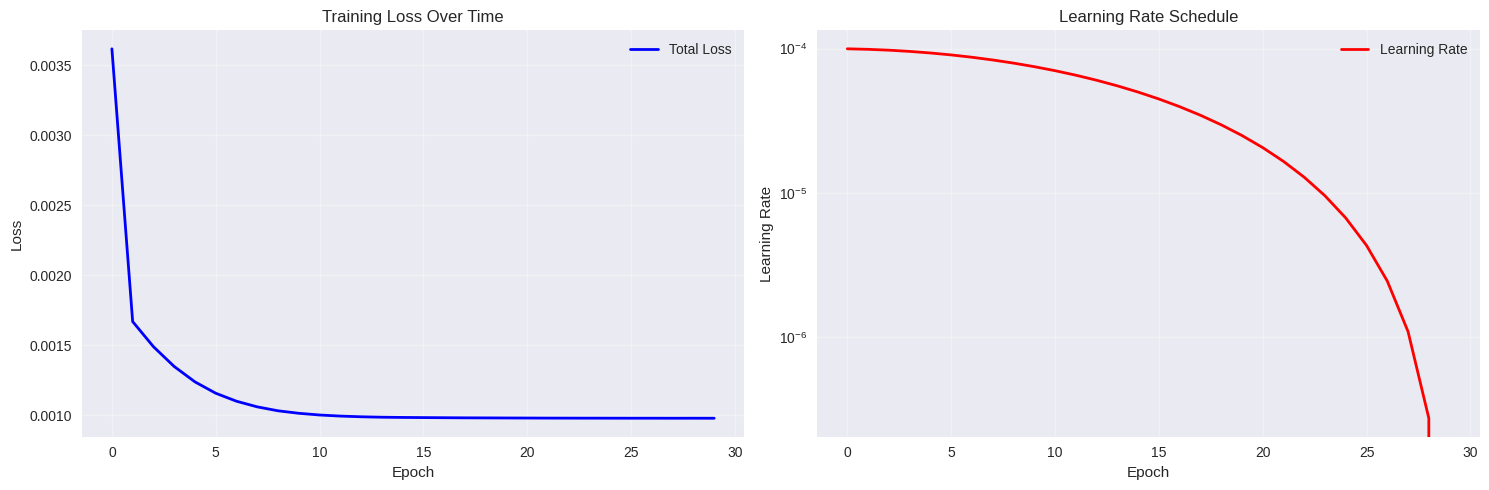

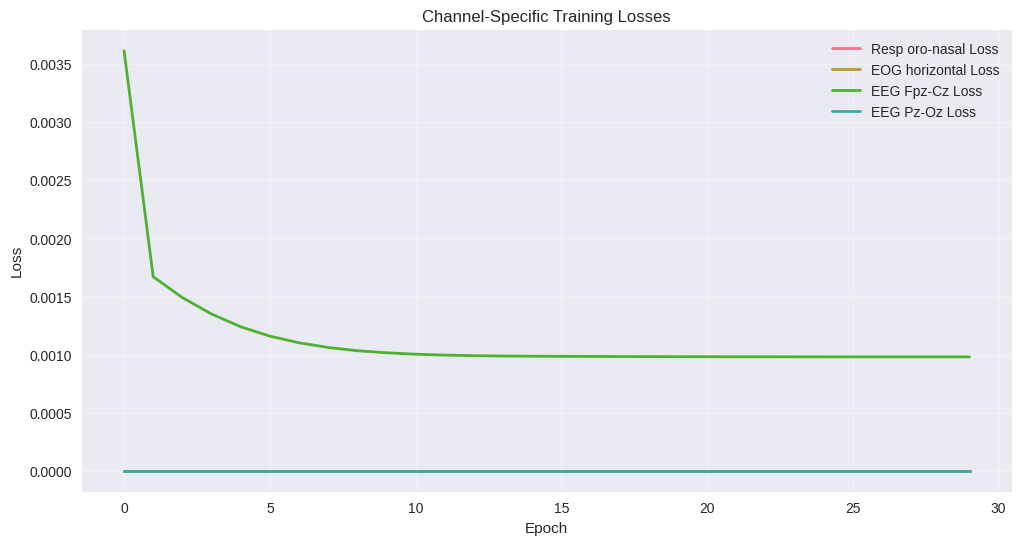

In [32]:
# COMPLETE PIPELINE EXECUTION
# This cell runs the entire pipeline from start to finish

print("="*80)
print("BILSTM + TRANSFORMER + KMEANS CLUSTERING PIPELINE")
print("="*80)

# Step 1: Import features (already done above)
if 'feature_dict' not in locals() or feature_dict is None:
    print("Step 1: Importing features...")
    feature_dict, input_dims, summary = import_all_saved_features('features_3s')
    if feature_dict is None:
        print("❌ Failed to import features. Please run the feature extraction first.")
        raise Exception("Features not available")
else:
    print("Step 1: ✓ Features already loaded")

# Step 2: Create sequences
print("\nStep 2: Creating sequences for model input...")
sequences_dict = create_sequences_from_features(
    feature_dict, 
    seq_length=20,  # 20 sequences of 3-second windows = 60 seconds total
    overlap=0.5     # 50% overlap between sequences
)
print(f"✓ Sequences created for {len(sequences_dict)} files")

# Step 3: Train model
print("\nStep 3: Training the BiLSTM + Transformer hybrid model...")
trained_model, training_history = train_hybrid_model(
    sequences_dict=sequences_dict,
    input_dims=input_dims,
    epochs=30,
    batch_size=16,
    learning_rate=1e-4,
    focus_channel='EEG Fpz-Cz'  # Focus on EEG channel for reconstruction
)
print("✓ Model training completed")

# Plot training history
plot_training_history(training_history)

In [34]:
# Step 4: Extract embeddings
print("\nStep 4: Extracting embeddings from trained model...")

def extract_embeddings_from_model(model, sequences_dict, batch_size=64):
    """
    Extract embeddings from the trained model using the provided sequences.
    
    Parameters:
    -----------
    model : BiLSTMTransformerHybrid
        Trained model
    sequences_dict : dict
        Dictionary of sequences for each file and channel
    batch_size : int
        Batch size for processing
        
    Returns:
    --------
    tuple: (embeddings, metadata)
        - embeddings: numpy.ndarray of extracted embeddings
        - metadata: list of metadata dictionaries for each embedding
    """
    dataset = MultiChannelSequenceDataset(sequences_dict)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=collate_multichannel_sequences,
        num_workers=0  # Set to 0 for Windows compatibility
    )
    
    embeddings = []
    metadata = []
    
    model.eval()
    with torch.no_grad():
        for batch_data, file_names, timestamps in tqdm(dataloader, desc="Extracting embeddings"):
            # Move data to device
            batch_data = {channel: data.to(device) for channel, data in batch_data.items()}
            
            # Forward pass to extract embeddings
            _, embedding_dict = model(batch_data, return_embeddings=True)
            
            # Collect embeddings and metadata
            for channel, embedding in embedding_dict.items():
                embeddings.append(embedding.cpu().numpy())
                metadata.extend([
                    {'file_name': file_name, 'timestamp_start': ts[0], 'timestamp_end': ts[-1], 'channel': channel}
                    for file_name, ts in zip(file_names, timestamps)
                ])
    
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings, metadata

# Extract embeddings
embeddings, metadata = extract_embeddings_from_model(
    model=trained_model,
    sequences_dict=sequences_dict,
    batch_size=64
)
print(f"✓ Embeddings shape: {embeddings.shape}")
print(f"✓ Metadata entries: {len(metadata)}")



Step 4: Extracting embeddings from trained model...


Extracting embeddings: 100%|██████████| 2594/2594 [00:33<00:00, 77.78it/s]



✓ Embeddings shape: (663848, 64)
✓ Metadata entries: 663848


In [40]:

# Step 5: Optimize KMeans and perform clustering
print("\nStep 5: Optimizing KMeans parameters and performing clustering...")

# Optimize KMeans parameters
print("  - Optimizing number of clusters...")
optimization_results = optimize_kmeans_parameters(
    embeddings,
    n_clusters_range=range(4, 9),  # Test 3 to 15 clusters
    random_state=42,
    verbose=True
)

# Get best parameters
best_n_clusters = optimization_results['best_params']['n_clusters']
print(f"\n  ✓ Best number of clusters: {best_n_clusters}")
print(f"  ✓ Best silhouette score: {optimization_results['best_score']:.4f}")

# Perform final clustering with best parameters
print("\n  - Performing final clustering...")
cluster_labels, clusterer, cluster_metrics = cluster_embeddings_kmeans(
    embeddings,
    n_clusters=best_n_clusters,
    random_state=42
)

print(f"\n✓ Clustering completed:")
print(f"  - Number of clusters: {cluster_metrics['n_clusters']}")
print(f"  - Silhouette score: {cluster_metrics['silhouette_score']:.4f}")
print(f"  - Total data points: {cluster_metrics['n_samples']}")


Step 5: Optimizing KMeans parameters and performing clustering...
  - Optimizing number of clusters...
Testing n_clusters=4
  Silhouette Score: 0.0478, Inertia: 2.17
Testing n_clusters=5
  Silhouette Score: 0.0478, Inertia: 2.17
Testing n_clusters=5
  Silhouette Score: 0.0442, Inertia: 2.13
Testing n_clusters=6
  Silhouette Score: 0.0442, Inertia: 2.13
Testing n_clusters=6
  Silhouette Score: 0.0428, Inertia: 2.09
Testing n_clusters=7
  Silhouette Score: 0.0428, Inertia: 2.09
Testing n_clusters=7
  Silhouette Score: 0.0425, Inertia: 2.06
Testing n_clusters=8
  Silhouette Score: 0.0425, Inertia: 2.06
Testing n_clusters=8
  Silhouette Score: 0.0417, Inertia: 2.03

  ✓ Best number of clusters: 4
  ✓ Best silhouette score: 0.0478

  - Performing final clustering...
  Silhouette Score: 0.0417, Inertia: 2.03

  ✓ Best number of clusters: 4
  ✓ Best silhouette score: 0.0478

  - Performing final clustering...

✓ Clustering completed:
  - Number of clusters: 4
  - Silhouette score: 0.0478
  -

In [51]:
# Step 7: Save results
print("\nStep 7: Saving results...")

# Check if all required variables exist - use globals() for notebook environment
required_vars = ['cluster_labels', 'embeddings', 'metadata', 'cluster_metrics', 'clusterer']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ Missing required variables: {missing_vars}")
    print("Please run the previous clustering steps first.")
    print("\nAvailable variables:")
    available_vars = [var for var in required_vars if var in globals()]
    for var in available_vars:
        print(f"  ✓ {var}: {type(globals()[var])}")
else:
    try:
        # Access variables from global namespace
        _cluster_labels = globals()['cluster_labels']
        _embeddings = globals()['embeddings']
        _metadata = globals()['metadata']
        _cluster_metrics = globals()['cluster_metrics']
        _clusterer = globals()['clusterer']
        
        print(f"✓ All required variables found")
        print(f"  - cluster_labels: {type(_cluster_labels)} with shape {_cluster_labels.shape}")
        print(f"  - embeddings: {type(_embeddings)} with shape {_embeddings.shape}")
        print(f"  - metadata: {type(_metadata)} with {len(_metadata)} entries")
        print(f"  - cluster_metrics: {type(_cluster_metrics)} with keys {list(_cluster_metrics.keys())}")
        print(f"  - clusterer: {type(_clusterer)}")
        
        # Calculate cluster statistics
        unique_clusters, cluster_counts = np.unique(_cluster_labels, return_counts=True)
        cluster_stats = {
            'n_clusters': len(unique_clusters),
            'silhouette_score': _cluster_metrics['silhouette_score'],
            'calinski_harabasz_score': _cluster_metrics['calinski_harabasz_score'],
            'davies_bouldin_score': _cluster_metrics['davies_bouldin_score'],
            'inertia': _cluster_metrics['inertia'],
            'n_samples': len(_cluster_labels),
            'n_features': _embeddings.shape[1],
            'cluster_sizes': {int(cluster): int(count) for cluster, count in zip(unique_clusters, cluster_counts)}
        }
        
        print(f"✓ Cluster statistics calculated: {len(cluster_stats)} metrics")
        
        # Save all results
        saved_files = save_clustering_results(
            embeddings=_embeddings,
            labels=_cluster_labels,
            metadata=_metadata,
            cluster_stats=cluster_stats,
            clusterer=_clusterer,
            save_dir='results',
            prefix='bilstm_transformer_kmeans_3s'
        )
        
        print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
        print(f"="*80)
        print(f"FINAL RESULTS SUMMARY:")
        print(f"  - Total embeddings processed: {len(_embeddings):,}")
        print(f"  - Optimal clusters discovered: {cluster_stats['n_clusters']}")
        print(f"  - Final silhouette score: {cluster_stats['silhouette_score']:.4f}")
        print(f"  - Files processed: {len(globals().get('feature_dict', {})) if 'feature_dict' in globals() else 'N/A'}")
        print(f"  - Total sequences: {len(_metadata):,}")
        
        print(f"\nCluster distribution:")
        for cluster_id, size in cluster_stats['cluster_sizes'].items():
            percentage = (size / len(_cluster_labels)) * 100
            print(f"  - Cluster {cluster_id}: {size:,} points ({percentage:.1f}%)")
        
        print(f"\nResults saved to: {saved_files.get('csv', 'N/A')}")
        print(f"="*80)
        
    except KeyError as e:
        print(f"❌ KeyError accessing variable: {e}")
        print(f"This suggests a variable naming issue or scope problem.")
        print(f"\nDebugging: Available global variables containing 'cluster' or 'embed':")
        for var_name in globals().keys():
            if 'cluster' in var_name.lower() or 'embed' in var_name.lower():
                print(f"  - {var_name}: {type(globals()[var_name])}")
        raise
        
    except Exception as e:
        print(f"❌ Error during results saving: {e}")
        print(f"Error type: {type(e).__name__}")
        print(f"\nDebugging info:")
        for var_name in required_vars:
            if var_name in globals():
                var_value = globals()[var_name]
                print(f"  ✓ {var_name}: {type(var_value)} ")
                if hasattr(var_value, 'shape'):
                    print(f"    Shape: {var_value.shape}")
                elif hasattr(var_value, '__len__'):
                    print(f"    Length: {len(var_value)}")
                if isinstance(var_value, dict):
                    print(f"    Keys: {list(var_value.keys())}")
            else:
                print(f"  ❌ {var_name}: Not found")
        raise


Step 7: Saving results...
✓ All required variables found
  - cluster_labels: <class 'numpy.ndarray'> with shape (663848,)
  - embeddings: <class 'numpy.ndarray'> with shape (663848, 64)
  - metadata: <class 'list'> with 663848 entries
  - cluster_metrics: <class 'dict'> with keys ['n_clusters', 'inertia', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'n_samples', 'n_features']
  - clusterer: <class 'sklearn.cluster._kmeans.KMeans'>
✓ Cluster statistics calculated: 8 metrics
✓ Results saved to results:
  - embeddings: bilstm_transformer_kmeans_3s_20250721_125353_embeddings.npy
  - labels: bilstm_transformer_kmeans_3s_20250721_125353_labels.npy
  - metadata: bilstm_transformer_kmeans_3s_20250721_125353_metadata.json
  - stats: bilstm_transformer_kmeans_3s_20250721_125353_cluster_stats.json
  - clusterer: bilstm_transformer_kmeans_3s_20250721_125353_clusterer.pkl
  - csv: bilstm_transformer_kmeans_3s_20250721_125353_results.csv

🎉 PIPELINE COMPLETED SUCCESSFULLY!